# Reduction of explanatory variables

In this stage of the analysis, we aim to identify a few "good" subsets according to different model selection criteria.

## Imports

In [1]:
# Set module path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import src.subset_selection as ss

## Import data

In [3]:
data_dir = Path("../data/processed/")
data_file = data_dir / "ca-schools.csv"

df = pd.read_csv(data_file, index_col=None)

df.head()

,students,teachers,calworks,lunch,computer,expenditure,income,english,math
0,-2433.792857,-118.167377,-12.735842,-42.664437,-236.383333,1072.503592,7.373412,-15.768155,690.000000
1,-2388.792857,-117.917377,2.170659,3.211462,-202.383333,-213.026682,-5.492588,-11.184822,661.900024
2,-1078.792857,-46.167375,41.786257,31.617364,-134.383333,189.547049,-6.338588,14.231847,650.900024
3,-2385.792857,-115.067376,23.229357,32.343965,-218.383333,1789.423514,-6.338588,-15.768155,643.500000
4,-1293.792857,-57.567376,19.862559,33.721765,-132.383333,-76.419748,-6.236255,-1.910478,639.900024


## Fit full model

In [4]:
fm = """math ~ students + teachers + calworks + np.square(calworks) + lunch + computer 
      + expenditure + income + np.square(income) + english + calworks:income
      + calworks:expenditure + expenditure:income"""

# Design matrices
y, X = dmatrices(fm, data=df, return_type='dataframe')

# Fit model
mod = sm.OLS(y, X)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   math   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     86.57
Date:                Thu, 28 Jul 2022   Prob (F-statistic):          3.12e-108
Time:                        12:08:04   Log-Likelihood:                -1547.9
No. Observations:                 420   AIC:                             3124.
Df Residuals:                     406   BIC:                             3180.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              651.7216 

## Determine best criterion values for all possible regression models of each size

In [6]:
from src.functions import savetable

table = ss.best_crit_values(X.values, y.values, 14)
savetable(table, "13-best-criterion-values.tex")

table

,Rp^2,Rap^2,Cp,AICp,SBCp,PRESSp
p,,,,,,
1,0.000,0.000,1113.444,2465.390,2473.470,148075.001
2,0.677,0.677,78.116,1992.287,2004.408,48022.390
3,0.712,0.711,26.752,1946.287,1962.448,43006.968
4,0.721,0.719,15.972,1935.928,1956.129,41963.277
5,0.724,0.722,12.164,1932.189,1956.431,41653.554
6,0.728,0.725,8.394,1928.409,1956.691,41288.911
7,0.730,0.726,7.288,1927.265,1959.587,41177.734
8,0.732,0.727,6.951,1926.883,1963.246,41156.725
9,0.733,0.728,6.480,1926.350,1966.752,41073.489


## Plot of variables selection criteria

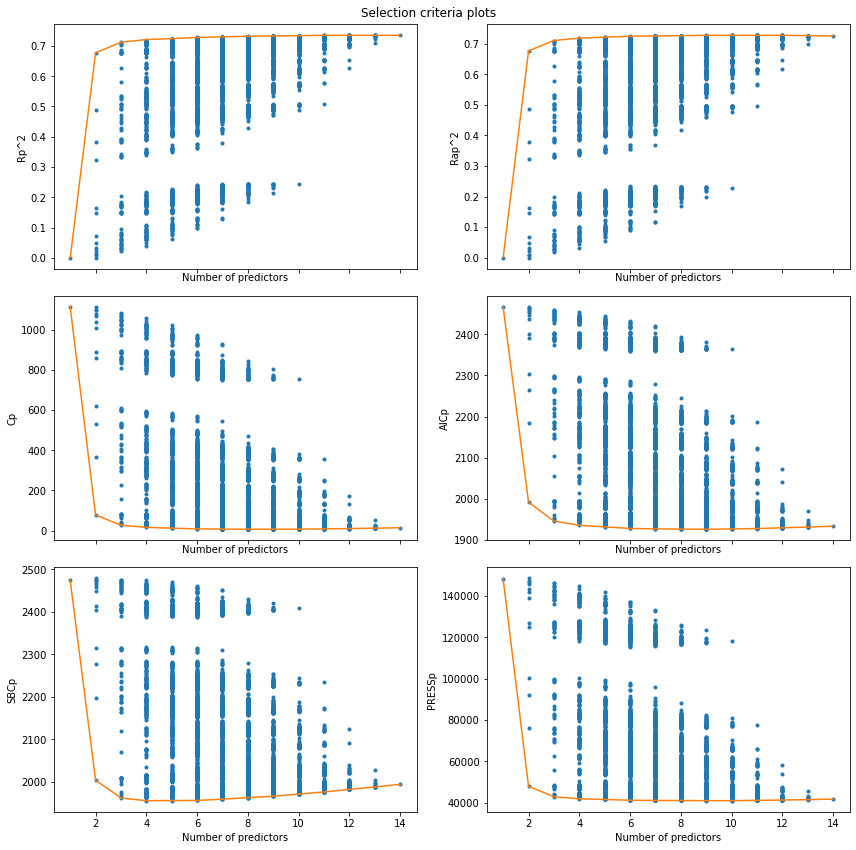

In [8]:
ss.sel_crit_plot(X.values, y.values, 14)

fig_name = "14-selection-criteria-plots"

fig_path = Path("../reports/figures/")
plt.savefig(fig_path / fig_name)

The criteria for model selection identify several "good" subsets containing differeny numbers of explanatory variables.

The $R_p^2$ criterion suggests subsets containing 2 or 3 predictors. The plot shows an "elbow" occurring above these numbers of predictors, which indicates that only marginal improvements in the model's explanatory power occur when additonal predictors are included.

A subset containing 9 predictors optimizes the $R_{a,p}^2$, $C_p$, $AIC_p$, and $PRESS_p$ criteria.

A subset with 4 predictors minimizes the $SBC_p$ criterion.

## Best Subsets

In [9]:
table = ss.best_subsets(X.values, y.values, 9)

savetable(table, "15-best-subsets.tex")

table

C:\Users\gfitz\OneDrive\Desktop\projects\ca-schools\src\functions.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  string = table.to_latex()


According to the various selection criteria, good subsets are

$X_0, X_5$ and $X_0, X_5, X_8$ according to $R_p^2$

$X_0, X_3, X_5, X_6, X_8, X_9, X_{10}, X_{11}, X_{13}$ according to $R_{a,p}^2$, $C_p$, $AIC_p$, and $PRESS_p$. This subset, however, includes an interaction term for expenditure, but it does not include expenditure as a linear term. We will add expenditure as a linear term before further examination.

$X_0, X_5, X_8, X_{10}$ according to $SBC_p$.

In addition, we will consider the subset $X_0, X_3, X_5, X_8, X_{10}, X_{11}$ because it performs well according to each of the selection criteria, contains a modest number of explanatory variables, and does not include any interaction terms for which the corresponding linear terms are missing.

Recall:

$X_0$ - Intercept

$X_1$ - Students

$X_2$ - Teachers

$X_3$ - Calworks

$X_4$ - Calworks squared

$X_5$ - Lunch

$X_6$ - Computer

$X_7$ - Expenditure

$X_8$ - Income

$X_9$ - Income squared

$X_{10}$ - English

$X_{11}$ - Calworks x income

$X_{12}$ - Calworks x expenditure

$X_{13}$ - Income x expenditure